# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

Сначала предобработаем данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Загрузим выборку.

In [2]:
train = pd.read_csv('orange_small_churn_train_data.csv', index_col = 0)

In [3]:
numeric_columns = np.array(train.columns[:190])
categorical_columns = np.array(train.columns[190:230])

Для построения модели выберем только те переменные, в которых есть хотя бы одно значение, не равное NaN.

In [4]:
not_null_numeric_columns = np.array(numeric_columns[np.array(pd.notnull(train[numeric_columns]).any())])
not_null_categorical_columns = np.array(categorical_columns[np.array(pd.notnull(train[categorical_columns]).any())])

Для упрощения модели выберем только те категориальные признаки, в которых не больше ста различных значений.

In [5]:
categorical_less_or_equal_100 = []
for var in not_null_categorical_columns:
    if len(train[var].unique()) <= 100:
        categorical_less_or_equal_100.append(var)
categorical_less_or_equal_100 = np.array(categorical_less_or_equal_100)

In [6]:
train_numeric = train[not_null_numeric_columns]
train_categorical = train[categorical_less_or_equal_100]
y_train = train['labels']

Заполним пропущенные значения.

In [7]:
train_numeric = train_numeric.fillna(0)
train_categorical = train_categorical.fillna('NA')

Применим к категориальным данным one-hot encoding с помощью DictVectorizer.

In [8]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse = False)
train_categorical = pd.DataFrame(dv.fit_transform(train_categorical.T.to_dict().values()))

In [9]:
X_train = pd.concat([train_numeric, train_categorical], axis = 1)

Разобьём обучающую выборку на 3 фолда методом stratified k-fold.

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 3)

Построим кривые обучения. В качестве модели выберем градиентный бустинг (xgboost.XGBClassifier).

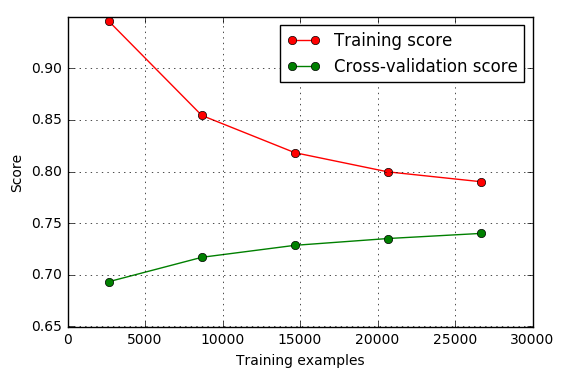

In [11]:
from sklearn.model_selection import learning_curve
import xgboost as xgb
train_sizes_abs, train_scores, test_scores = learning_curve(xgb.XGBClassifier(), X_train, y_train, cv = skf,
                                                            scoring = 'roc_auc')
train_scores_mean = np.mean(train_scores, axis = 1)
test_scores_mean = np.mean(test_scores, axis = 1)
plt.figure()
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color = 'r', label = 'Training score')
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
plt.legend(loc = 'best')
plt.show()

Видно, что с увеличением размера обучающей выборки качество на тестовой выборке продолжает расти. Следовательно, для построения модели нужно использовать всю выборку.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Для начала оценим качество модели без весов.

In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, scoring = 'roc_auc', cv = skf)
print 'Без весов: ', scores.mean()

Без весов:  0.739371390953


Используем три варианта весов: 1:5, 1:10, 1:13.

In [13]:
sample_weight1 = np.array([1 if x == -1 else 5 for x in y_train])
sample_weight2 = np.array([1 if x == -1 else 10 for x in y_train])
sample_weight3 = np.array([1 if x == -1 else 13 for x in y_train])
for sample_weight in sample_weight1, sample_weight2, sample_weight3:
    scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, scoring = 'roc_auc', cv = skf,
                             fit_params = {'sample_weight': sample_weight})
    print scores.mean()

0.737038471712
0.735925157592
0.7356204807


Качество поменялось. Видим, что наибольшее качество достигается при весах 1:5, однако это всё равно меньше, чем у модели без весов. Поэтому далее веса использовать не будем.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Попробуем убрать 10000, 20000 и 35000 объектов класса -1.

In [14]:
indices = np.array(y_train[y_train == -1].index)
np.random.seed(0)
for size in 10000, 20000, 35000:
    indices_to_remove = np.random.choice(indices, size = size, replace = False)
    scores = cross_val_score(xgb.XGBClassifier(), X_train.drop(indices_to_remove), y_train.drop(indices_to_remove),
                             scoring = 'roc_auc', cv = skf)
    print size, ':', scores.mean()

10000 : 0.737970202562
20000 : 0.738587331131
35000 : 0.722598772375


Качество поменялось. Видим, что наибольшее качество достигается при удалении 20000 объектов, однако это всё равно меньше, чем у модели без использования undersampling. Поэтому далее undersampling использовать не будем.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Изначально мы заполняли пропущенные значения нулями. Посмотрим на качество модели при такой стратегии.

In [15]:
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, scoring = 'roc_auc', cv = skf)
print 'Заполнение нулями: ', scores.mean()

Заполнение нулями:  0.739371390953


Попробуем заполнить пропущенные значения средними по столбцам.

In [13]:
train_numeric_means = train[not_null_numeric_columns].fillna(train[not_null_numeric_columns].mean(0), axis = 0)
X_train_means = pd.concat([train_numeric_means, train_categorical], axis = 1)
scores = cross_val_score(xgb.XGBClassifier(), X_train_means, y_train, scoring = 'roc_auc', cv = skf)
print 'Заполнение средними: ', scores.mean()

Заполнение средними:  0.740679192064


Попробуем заполнить пропущенные значения медианами по столбцам.

In [17]:
train_numeric_medians = train[not_null_numeric_columns].fillna(train[not_null_numeric_columns].median(0), axis = 0)
X_train_medians = pd.concat([train_numeric_medians, train_categorical], axis = 1)
scores = cross_val_score(xgb.XGBClassifier(), X_train_medians, y_train, scoring = 'roc_auc', cv = skf)
print 'Заполнение медианами: ', scores.mean()

Заполнение медианами:  0.734332618712


Видим, что лучшее качество достигается при заполнении пропущенных значений средними. Далее будем использовать именно эту стратегию.

In [14]:
train_numeric = train_numeric_means
X_train = X_train_means

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

Изначально для обработки категориальных признаков мы использовали one-hot encoding. Посмотрим на качество модели при такой стратегии.

In [19]:
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, scoring = 'roc_auc', cv = skf)
print 'One-hot encoding: ', scores.mean()

One-hot encoding:  0.740679192064


Попробуем label encoding: будем кодировать каждую категорию с помощью одного целочисленного значения.

In [20]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_categorical_le = train[not_null_categorical_columns]
train_categorical_le = train_categorical_le.fillna('NA')
for var in not_null_categorical_columns:
    train_categorical_le[var] = le.fit_transform(train_categorical_le[var])
X_train_le = pd.concat([train_numeric, train_categorical_le], axis = 1)
scores = cross_val_score(xgb.XGBClassifier(), X_train_le, y_train, scoring = 'roc_auc', cv = skf)
print 'Label encoding: ', scores.mean()

Label encoding:  0.737687905618


Попробуем кодировать частотами.

In [15]:
train_categorical_freq = train[not_null_categorical_columns]
train_categorical_freq = train_categorical_freq.fillna('NA')
for var in not_null_categorical_columns:
    value_counts = train_categorical_freq[var].value_counts()
    train_categorical_freq[var] = np.array([value_counts[x] for x in train_categorical_freq[var]])
X_train_freq = pd.concat([train_numeric, train_categorical_freq], axis = 1)
scores = cross_val_score(xgb.XGBClassifier(), X_train_freq, y_train, scoring = 'roc_auc', cv = skf)
print 'Frequencies encoding: ', scores.mean()

Frequencies encoding:  0.744447036908


Видим, что лучшее качество достигается при кодировании категориальных признаков частотами. Далее будем использовать именно эту стратегию.

In [16]:
train_categorical = train_categorical_freq
X_train = X_train_freq

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

Сначала удалим признаки с нулевой дисперсией.

In [17]:
from sklearn.feature_selection import VarianceThreshold
X_train_vt = VarianceThreshold().fit_transform(X_train)

Попробуем отобрать 40 лучших признаков, используя ANOVA F-value.

In [24]:
from sklearn.feature_selection import SelectKBest
X_f_classif = SelectKBest(k = 40).fit_transform(X_train_vt, y_train)
scores = cross_val_score(xgb.XGBClassifier(), X_f_classif, y_train, scoring = 'roc_auc', cv = skf)
print 'ANOVA F-value: ', scores.mean()

ANOVA F-value:  0.74588496742


Качество чуть улучшилось. Теперь попробуем построить регрессию Lasso и убрать признаки с нулевыми весами.

In [18]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter = 10000).fit(X_train_vt, y_train)
nonzero_features = np.flatnonzero(lasso.coef_)
X_train_lasso = X_train_vt.take(nonzero_features, axis = 1)
scores = cross_val_score(xgb.XGBClassifier(), X_train_lasso, y_train, scoring = 'roc_auc', cv = skf)
print 'Lasso: ', scores.mean()

Lasso:  0.688986238729


Качество сильно ухудшилось. Далее будем использовать первую стратегию.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

Будем подбирать параметры max_depth и learning_rate.

In [26]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth' : [3, 6, 10], 'learning_rate' : [0.01, 0.05, 0.1, 0.2]}
search = GridSearchCV(xgb.XGBClassifier(), param_grid, scoring = 'roc_auc', cv = skf)
search.fit(X_f_classif, y_train)
print 'Best params: ', search.best_params_
print 'Best score: ', search.best_score_

Best params:  {'learning_rate': 0.1, 'max_depth': 3}
Best score:  0.74588499581


Видим, что оптимальными параметрами являются learning_rate = 0.1 и max_depth = 3. Однако качество у нас практически не изменилось, так как эти же параметры являются в XGBClassifier параметрами по умолчанию.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

Отсортируем признаки по feature\_importances_.

In [27]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
features = pd.DataFrame({'feature' : X_train.columns, 'feature_importance' : xgb_clf.feature_importances_})
features.sort_values('feature_importance', ascending = False)

,feature,feature_importance
114,Var126,0.144105
199,Var217,0.069869
172,Var189,0.059680
182,Var199,0.058224
175,Var192,0.053857
101,Var113,0.046579
62,Var73,0.046579
69,Var81,0.040757
63,Var74,0.034934
46,Var57,0.032023


Видим, что наибольший вклад в модель внесли признаки Var126, Var217, Var189, Var199, Var192. Наименьший вклад в модель внесли признаки, находящиеся внизу выборки, такие как Var122, Var124, Var127 и т.д.

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [28]:
X_train = X_f_classif

In [29]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
predictions = xgb_clf.predict(X_train)
probabilities = [x[1] for x in xgb_clf.predict_proba(X_train)]
false_positives = X_train[np.array(y_train == -1 & np.logical_and(predictions == 1, probabilities >= 0.9))]
false_negatives = X_train[np.array(y_train == 1 & np.logical_and(predictions == -1, probabilities <= 0.1))]

Посмотрим на объекты, с высокой вероятностью отнесённые к классу 1, хотя принадлежащие классу -1.

In [30]:
false_positives

array([[  1.16200000e+03,   7.00000000e+00,   2.88000000e+02, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       [  1.12000000e+02,   0.00000000e+00,   0.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       [  7.70000000e+01,   0.00000000e+00,   0.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       ..., 
       [  7.98000000e+02,   0.00000000e+00,   0.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       [  8.05000000e+02,   7.00000000e+00,   0.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       [  5.04000000e+02,   0.00000000e+00,   0.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04]])

Видим, что на первый взгляд они довольно похожи. Посмотрим на объекты в выборке, действительно принадлежащие классу 1.

In [31]:
X_train[np.array(y_train == 1)]

array([[  1.53300000e+03,   7.00000000e+00,   4.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       [  2.52000000e+02,   0.00000000e+00,   0.00000000e+00, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       [  5.85900000e+03,   7.00000000e+00,   1.04000000e+02, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04],
       ..., 
       [  2.31000000e+02,   0.00000000e+00,   1.60000000e+01, ...,
          2.81120000e+04,   2.62110000e+04,   7.85000000e+03],
       [  1.27400000e+03,   7.00000000e+00,   5.96000000e+02, ...,
          2.81120000e+04,   2.62110000e+04,   7.85000000e+03],
       [  9.87000000e+02,   7.00000000e+00,   1.47600000e+03, ...,
          2.81120000e+04,   2.62110000e+04,   2.27770000e+04]])

Видим, что они также похожи на false_positives. Возможная причина таких ошибок - похожесть объектов false_positives на объекты класса 1.

Посмотрим на объекты, с высокой вероятностью отнесённые к классу -1, хотя принадлежащие классу 1.

In [32]:
false_negatives

array([], shape=(0, 40), dtype=float64)

Таких объектов нет.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Модель уже построена. Я использовала заполнение пропущенных значений средними, кодирование категориальных признаков частотами, выбрала 40 наиболее важных переменных с помощью ANOVA F-value. Все параметры модели я использовала по умолчанию.

In [33]:
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Можно добавить новые переменные - полиномиальные или индикаторы того, пропущено значение или нет. Можно отмасштабировать вещественные признаки. Также можно попробовать подобрать другие параметры модели.